# Catboost

In [1]:
import datetime
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder

from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve



import lightgbm as lgb
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier




#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import shap

# import missingno as msno

import warnings
warnings.filterwarnings("ignore")

D:\Software\anaconda\envs\test\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
input_path = './input/xiaoerxiaochuan/'
output_path = './output/GBDT/'

In [3]:
# pd.set_option('max_columns',100)
# pd.set_option('max_rows',900)

pd.set_option('max_colwidth',200)

df = pd.read_excel(input_path+'data.xlsx')
df = df.dropna(axis=0,subset=['咳嗽分型']).reset_index()
df.drop(index=[11,82],inplace=True)

In [4]:
medicines = []
for i in df.columns:
    if re.match('药\d$',i):
        medicines += df[i].tolist()
medicines = list(set(medicines))
for item in ['？', np.nan, '1.桑白皮', '（1）炙黄芪', '（1）桑叶', '葶苈子（包）', '地肤子（包）', '黛蛤散','葶苈子（包)','葶苈','白']:
    if item in medicines:
        medicines.remove(item)
X = pd.DataFrame()
for i,row in df.iterrows():
    for j in row:
        if j in medicines:
            X.loc[i,j] = row[str(row[row==j].index.tolist()[0])+'剂量(g)']
X.replace(np.nan,0,inplace=True)
X['桑叶/桑白皮'].replace('各\d',4,regex=True,inplace=True)
X['煅龙牡'].replace('各\d',4,regex=True,inplace=True)
y = df['咳嗽分型']
y.iplot(kind='hist', title= '咳嗽分型')
X = pd.concat([X,y],axis=1)
X = X.drop(X[(X['咳嗽分型']!='热性哮喘') & (X['咳嗽分型'] != '寒性哮喘')].index)
X['咳嗽分型'].iplot(kind='hist', title= '咳嗽分型')

In [5]:
accuracy= []
recall =[]
roc_auc= []
precision = []
le = LabelEncoder()

In [6]:
X

,金银花,连翘,薄黄,桔梗,桑叶,板蓝根,前胡,浙贝母,辛夷,黛蛤粉,...,白芷,煅龙牡,黄苓,葶苏子,决明子,莱菔子,桑叶/桑白皮,黄岑,炙乌梢,咳嗽分型
0,10.0,10.0,6.0,6.0,10.0,10.0,10.0,6.0,6.0,10.0,...,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,热性哮喘
1,0.0,0.0,0.0,6.0,10.0,0.0,10.0,6.0,6.0,10.0,...,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,热性哮喘
2,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,热性哮喘
3,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,热性哮喘
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,热性哮喘
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0,0.0,6.0,寒性哮喘
83,0.0,0.0,0.0,6.0,0.0,0.0,10.0,0.0,6.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,4,10.0,0.0,热性哮喘
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,4,0.0,0.0,0.0,0.0,0,0.0,0.0,寒性哮喘
85,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0,6.0,0.0,寒性哮喘


In [7]:
y

0      热性哮喘
1      热性哮喘
2      热性哮喘
3      热性哮喘
4      外寒内热
      ...  
81     寒性哮喘
83     热性哮喘
84     寒性哮喘
85     寒性哮喘
86     寒性哮喘
Name: 咳嗽分型, Length: 85, dtype: object

In [8]:
y = X['咳嗽分型']
y = le.fit_transform(y)
X.drop(columns='咳嗽分型',inplace=True)
cols = X.columns
X

,金银花,连翘,薄黄,桔梗,桑叶,板蓝根,前胡,浙贝母,辛夷,黛蛤粉,...,生大黄,白芷,煅龙牡,黄苓,葶苏子,决明子,莱菔子,桑叶/桑白皮,黄岑,炙乌梢
0,10.0,10.0,6.0,6.0,10.0,10.0,10.0,6.0,6.0,10.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,0.0,0.0,0.0,6.0,10.0,0.0,10.0,6.0,6.0,10.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,6.0
83,0.0,0.0,0.0,6.0,0.0,0.0,10.0,0.0,6.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,4,10.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,4,0.0,0.0,0.0,0.0,0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0,6.0,0.0


In [9]:
scale = StandardScaler()
X =scale.fit_transform(X)

In [10]:
X

array([[ 3.02076149,  3.89871774,  5.09901951, ..., -0.19611614,
        -0.24936467, -0.1118034 ],
       [-0.33104236, -0.25649459, -0.19611614, ..., -0.19611614,
        -0.24936467, -0.1118034 ],
       [-0.33104236, -0.25649459, -0.19611614, ..., -0.19611614,
        -0.24936467, -0.1118034 ],
       ...,
       [-0.33104236, -0.25649459, -0.19611614, ..., -0.19611614,
        -0.24936467, -0.1118034 ],
       [-0.33104236, -0.25649459, -0.19611614, ..., -0.19611614,
         2.63614085, -0.1118034 ],
       [-0.33104236, -0.25649459, -0.19611614, ..., -0.19611614,
         2.63614085, -0.1118034 ]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost_5 = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=3,allow_writing_files=False)


catboost_5.fit(X_train, y_train,eval_set=(X_test, y_test))

y_pred = catboost_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_adjusted_weight_3']
result_df3 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df3

,Accuracy,Recall,Roc_Auc,Precision
Catboost_adjusted_weight_3,0.76,1.0,0.5,0.76


<BarContainer object of 10 artists>

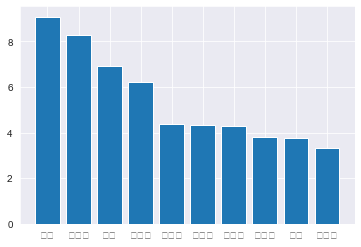

In [12]:
catboost_feature_importances=pd.DataFrame(data=[catboost_5.feature_importances_],columns=cols).sort_values(by=0,axis=1,ascending=False)
# list(catboost_feature_importances.columns)
plt.bar(catboost_feature_importances.columns[:10],catboost_feature_importances.values.squeeze()[:10])

<BarContainer object of 10 artists>

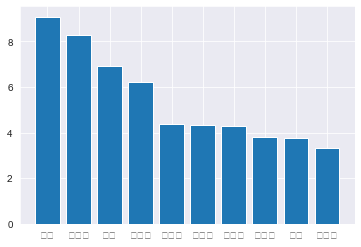

In [13]:
catboost_feature_importances=pd.DataFrame(data=[catboost_5.get_feature_importance(type='PredictionValuesChange')],columns=cols).sort_values(by=0,axis=1,ascending=False)
plt.bar(catboost_feature_importances.columns[:10],catboost_feature_importances.values.squeeze()[:10])

In [14]:
# catboost_feature_importances=pd.DataFrame(data=[catboost_5.get_feature_importance(type='ShapValues')],columns=cols).sort_values(by=0,axis=1,ascending=False)
# plt.bar(catboost_feature_importances.columns[:10],catboost_feature_importances.values.squeeze()[:10])

In [15]:
# fig, ax = plt.subplots(figsize=(8, 8))
# plot_confusion_matrix(catboost_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

In [16]:
explainercat = shap.TreeExplainer(catboost_5)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)

In [17]:
SHAP_CatBoost=pd.DataFrame(data=shap_values_cat_train,columns=cols).sum(axis=0).sort_values(ascending=False)
SHAP_CatBoost.drop(index=SHAP_CatBoost[SHAP_CatBoost==0].index,inplace=True)
SHAP_CatBoost.round(3).to_csv(output_path+'Catboost_SHAP.csv')

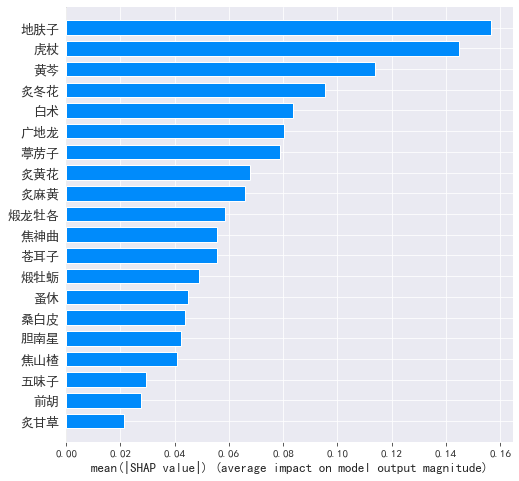

In [18]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
shap.summary_plot(shap_values_cat_train, cols, plot_type="bar",plot_size=(8,8))

In [19]:
# fig = plt.subplots(figsize=(6,6),dpi=200)
# ax = shap.summary_plot(shap_values_cat_train, cols,plot_type="dot")

# LightGBM

- split:分裂时，特征用到的次数
- gain:信息增益

In [20]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
#from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import shap
# import missingno as msno
import warnings
warnings.filterwarnings("ignore")
print(datetime.datetime.now(),'\n依赖库加载完毕!')

2022-06-04 20:22:55.587263 
依赖库加载完毕!


In [21]:
df = pd.read_excel(input_path+'data.xlsx')
df = df.dropna(axis=0,subset=['咳嗽分型']).reset_index()
df.drop(index=[11,82],inplace=True)
medicines = []
for i in df.columns:
    if re.match('药\d$',i):
        medicines += df[i].tolist()
medicines = list(set(medicines))
for item in ['？', np.nan, '1.桑白皮', '（1）炙黄芪', '（1）桑叶', '葶苈子（包）', '地肤子（包）', '黛蛤散','葶苈子（包)','葶苈','白']:
    if item in medicines:
        medicines.remove(item)
X = pd.DataFrame()
for i,row in df.iterrows():
    for j in row:
        if j in medicines:
            X.loc[i,j] = row[str(row[row==j].index.tolist()[0])+'剂量(g)']
X.replace(np.nan,0,inplace=True)
X['桑叶/桑白皮'].replace('各\d',4,regex=True,inplace=True)
X['煅龙牡'].replace('各\d',4,regex=True,inplace=True)
y = df['咳嗽分型']
# y.iplot(kind='hist', title= '咳嗽分型')
X = pd.concat([X,y],axis=1)
X = X.drop(X[(X['咳嗽分型']!='热性哮喘') & (X['咳嗽分型'] != '寒性哮喘')].index)
# X['咳嗽分型'].iplot(kind='hist', title= '咳嗽分型')
accuracy= []
recall =[]
roc_auc= []
precision = []
le = LabelEncoder()
y = X['咳嗽分型']
y = le.fit_transform(y)
X.drop(columns='咳嗽分型',inplace=True)
cols = X.columns
X[:] = StandardScaler().fit_transform(X)
print(datetime.datetime.now(),'\n数据预处理完成!')

2022-06-04 20:22:55.963266 
数据预处理完成!


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgbmc_5=lgb.LGBMClassifier(random_state=0,scale_pos_weight=3)

lgbmc_5.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)

y_pred = lgbmc_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_adjusted_weight_5']
result_df9 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df9

,Accuracy,Recall,Roc_Auc,Precision
LightGBM_adjusted_weight_5,0.76,1.0,0.5,0.76


<BarContainer object of 10 artists>

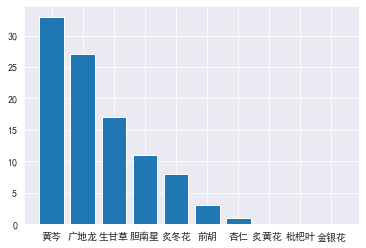

In [23]:
lgb_feature_importances=pd.DataFrame(data=[lgbmc_5.feature_importances_],columns=cols).sort_values(by=0,axis=1,ascending=False)
plt.bar(lgb_feature_importances.columns[:10],lgb_feature_importances.values.squeeze()[:10])

In [24]:
# fig, ax = plt.subplots(figsize=(8, 8))
# plot_confusion_matrix(lgbmc_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

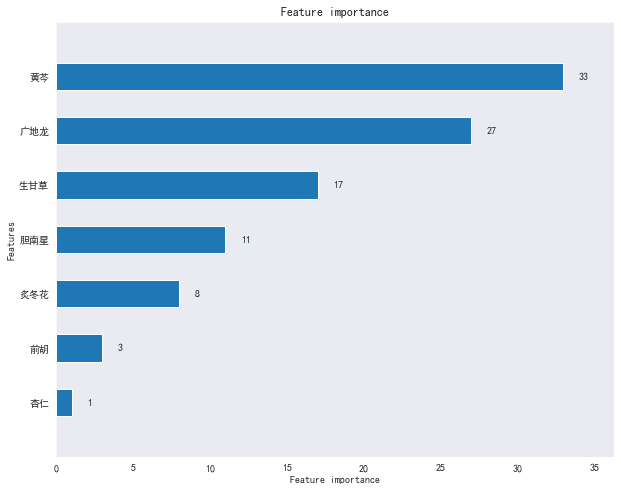

In [25]:
from lightgbm import plot_importance
_,ax = plt.subplots(figsize=(10,8))
plot_importance(lgbmc_5,importance_type='split',grid=False,height=0.5,ax=ax,max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

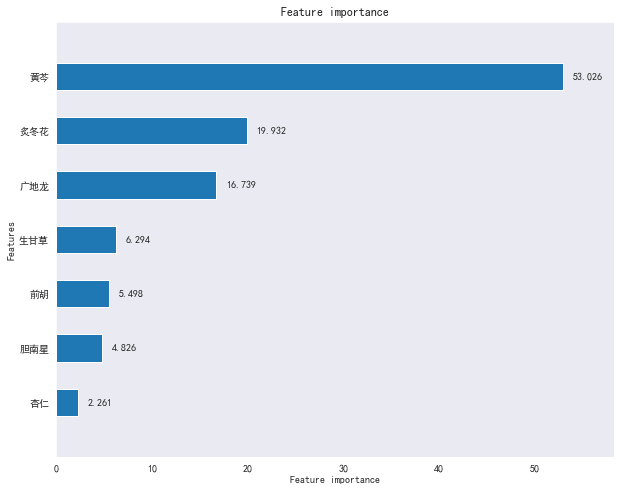

In [26]:
_,ax = plt.subplots(figsize=(10,8))
plot_importance(lgbmc_5,importance_type='gain',grid=False,height=0.5,ax=ax,max_num_features=10)

Text(0.5, 0, 'Permutation Importance')

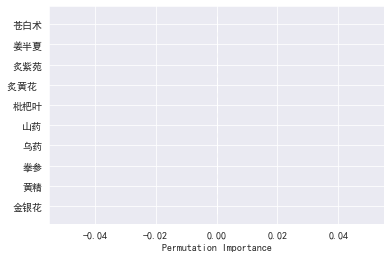

In [27]:
from sklearn.inspection import permutation_importance
lgb_permutation_importance = permutation_importance(lgbmc_5,X_test,y_test,random_state=77)
sorted_idx = lgb_permutation_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx][:10],lgb_permutation_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")
# lgb_permutation_importance.importances_mean[sorted_idx][:10]

In [28]:
explainerlgbmc = shap.TreeExplainer(lgbmc_5)
shap_values_LightGBM_test = explainerlgbmc.shap_values(X_test)
shap_values_LightGBM_train = explainerlgbmc.shap_values(X_train)
print(datetime.datetime.now(),'LightGBM SHAP value训练完成!')

2022-06-04 20:22:57.242262 LightGBM SHAP value训练完成!


In [29]:
SHAP_LightGBM=pd.DataFrame(data=shap_values_LightGBM_train[1],columns=cols).sum(axis=0).sort_values(ascending=False)
SHAP_LightGBM.drop(index=SHAP_LightGBM[SHAP_LightGBM==0].index,inplace=True)
SHAP_LightGBM.to_csv(output_path+'LightGBM_SHAP.csv')

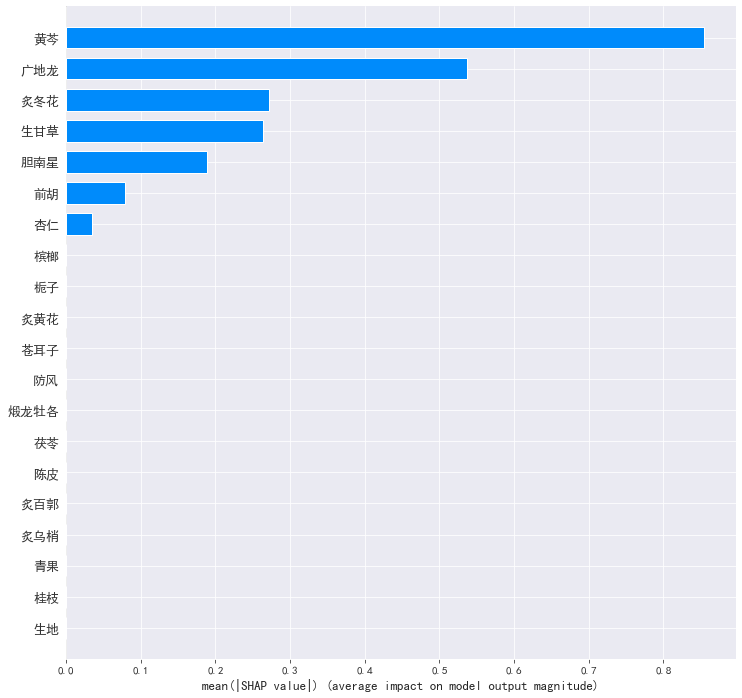

In [30]:
shap.summary_plot(shap_values_LightGBM_train[1],cols,plot_type="bar",plot_size=(12,12))

In [31]:
# fig = plt.subplots(figsize=(6,6),dpi=200)
# ax = shap.summary_plot(shap_values_LightGBM_train[1], cols,plot_type="dot")

# XGBoost

- 信息增益gain：节点分裂时，该特征带来的信息增益优化的平均值
- 权重weight: 子树模型分裂时，用到的特征次数
- cover:特征下的叶子节点涵盖的样本数除以用来分裂的次数，分裂越靠近根部，cover越大
- permutation:如果这个特征很重要，那么我们打散样本中该特征的值，最后优化目标将折损，这个折损程度就是这个特征的重要程度，对非线性模型更加友好
- SHAP: 轮流去掉每一个特征，算出剩下的特征的贡献情况，以此来推导出特征的边际贡献


In [32]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
#from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import shap
# import missingno as msno
import warnings
warnings.filterwarnings("ignore")
print(datetime.datetime.now(),'\n依赖库加载完毕!')

2022-06-04 20:22:57.435360 
依赖库加载完毕!


In [33]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
print(datetime.datetime.now(),'\nmatplotlib中文设置完成!')

2022-06-04 20:22:57.444316 
matplotlib中文设置完成!


In [34]:
df = pd.read_excel('./input/xiaoerxiaochuan/data.xlsx')
df = df.dropna(axis=0,subset=['咳嗽分型']).reset_index()
df.drop(index=[11,82],inplace=True)
medicines = []
for i in df.columns:
    if re.match('药\d$',i):
        medicines += df[i].tolist()
medicines = list(set(medicines))
for item in ['？', np.nan, '1.桑白皮', '（1）炙黄芪', '（1）桑叶', '葶苈子（包）', '地肤子（包）', '黛蛤散','葶苈子（包)','葶苈','白']:
    if item in medicines:
        medicines.remove(item)
X = pd.DataFrame()
for i,row in df.iterrows():
    for j in row:
        if j in medicines:
            X.loc[i,j] = row[str(row[row==j].index.tolist()[0])+'剂量(g)']
X.replace(np.nan,0,inplace=True)
X['桑叶/桑白皮'].replace('各\d',4,regex=True,inplace=True)
X['煅龙牡'].replace('各\d',4,regex=True,inplace=True)
y = df['咳嗽分型']
# y.iplot(kind='hist', title= '咳嗽分型')
X = pd.concat([X,y],axis=1)
X = X.drop(X[(X['咳嗽分型']!='热性哮喘') & (X['咳嗽分型'] != '寒性哮喘')].index)
# X['咳嗽分型'].iplot(kind='hist', title= '咳嗽分型')
accuracy= []
recall =[]
roc_auc= []
precision = []
le = LabelEncoder()
y = X['咳嗽分型']
y = le.fit_transform(y)
X.drop(columns='咳嗽分型',inplace=True)
cols = X.columns
X[:] = StandardScaler().fit_transform(X.values)
print(datetime.datetime.now(),'\n数据预处理完成!')

2022-06-04 20:22:57.918322 
数据预处理完成!


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgbc_3 = xgb.XGBClassifier(random_state=0,scale_pos_weight=3,booster='gbtree',eval_metric='error')

xgbc_3.fit(X_train, y_train)
y_pred = xgbc_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

print(f"accuracy:{sum(accuracy)/5:.3f}\n",f"recall:{sum(recall)/5:.3f}\n",f"roc_auc:{sum(roc_auc)/5:.3f}\n",f"precision{sum(precision)/5:.3f}\n")
# result_df6 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=['XGBoost_adjusted_weight_3'])
# result_df6

accuracy:0.144
 recall:0.179
 roc_auc:0.106
 precision0.155



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

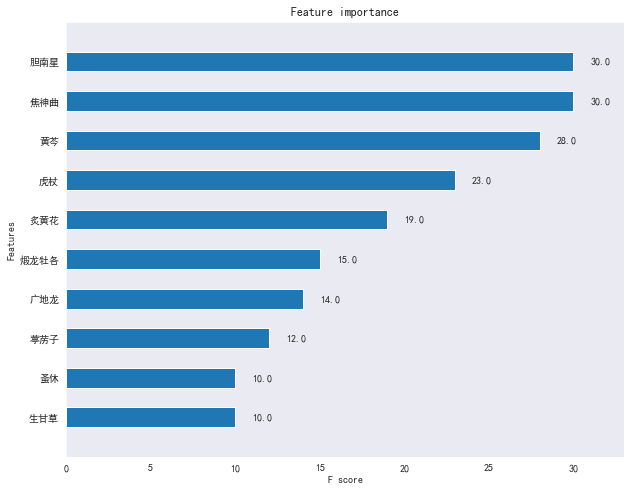

In [36]:
# 权重weight:在子树模型分裂时，用到的特征次数
from xgboost import plot_importance

_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='weight',grid=False,height=0.5,ax=ax,max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

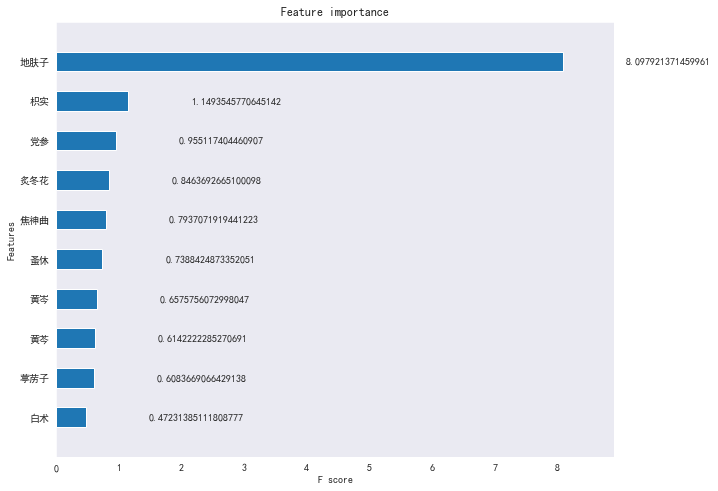

In [37]:
_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='gain',grid=False,height=0.5,ax=ax,max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

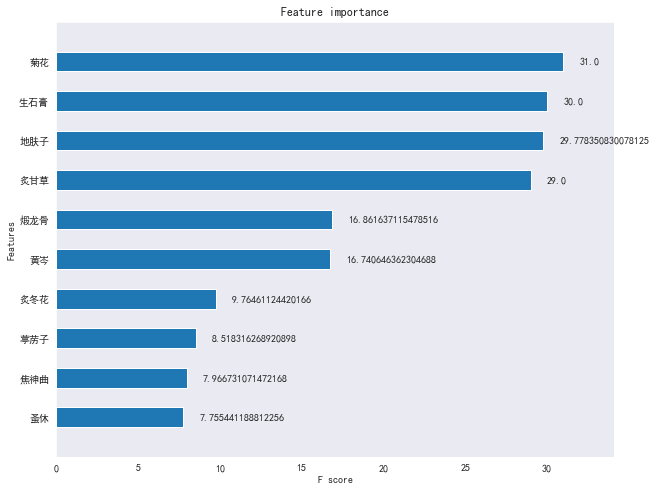

In [38]:
_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='cover',grid=False,height=0.5,ax=ax,max_num_features=10)

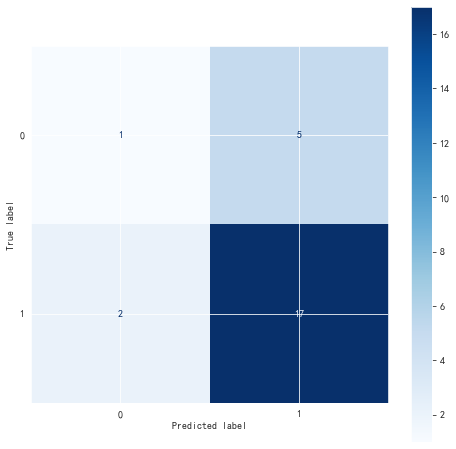

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_3, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

## SHAP Feature Importance


In [40]:
explainerxgbc = shap.TreeExplainer(xgbc_3)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)
print(datetime.datetime.now(),"\nXGBoost SHAP value训练完成!")

2022-06-04 20:22:58.622269 
XGBoost SHAP value训练完成!


In [41]:
shap_values_XGBoost_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.04648061,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05739193,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05739193,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.05642096,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0481404 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0428399 ,
        0.        ]], dtype=float32)

In [42]:
SHAP_XGBoost=pd.DataFrame(data=shap_values_XGBoost_train,columns=X_train.columns).mean(axis=0).sort_values(ascending=False)
SHAP_XGBoost.drop(index=SHAP_XGBoost[SHAP_XGBoost==0].index,inplace=True)
SHAP_XGBoost.round(3).to_csv(output_path+'XGBoost_SHAP.csv')
print(datetime.datetime.now())

2022-06-04 20:22:58.649262


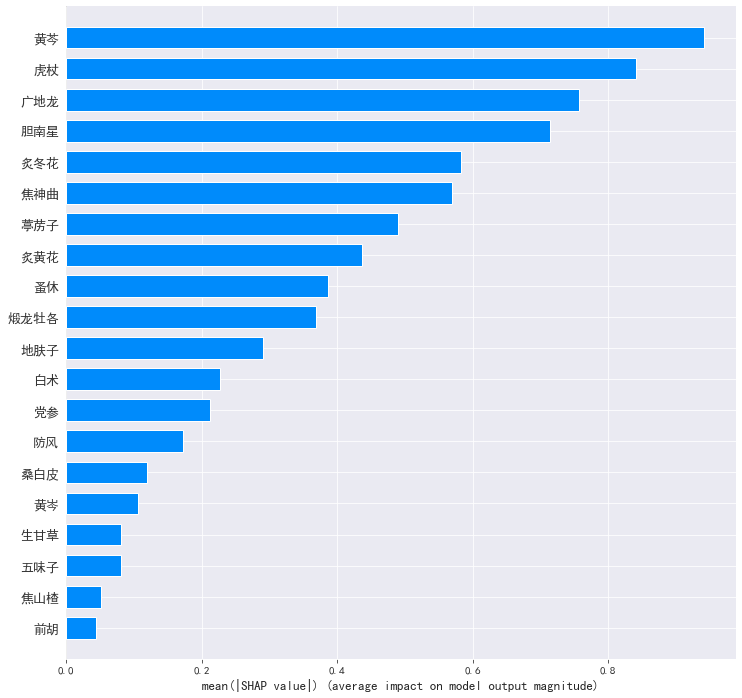

In [43]:
shap.summary_plot(shap_values_XGBoost_train, cols,plot_type="bar",plot_size=(12,12))

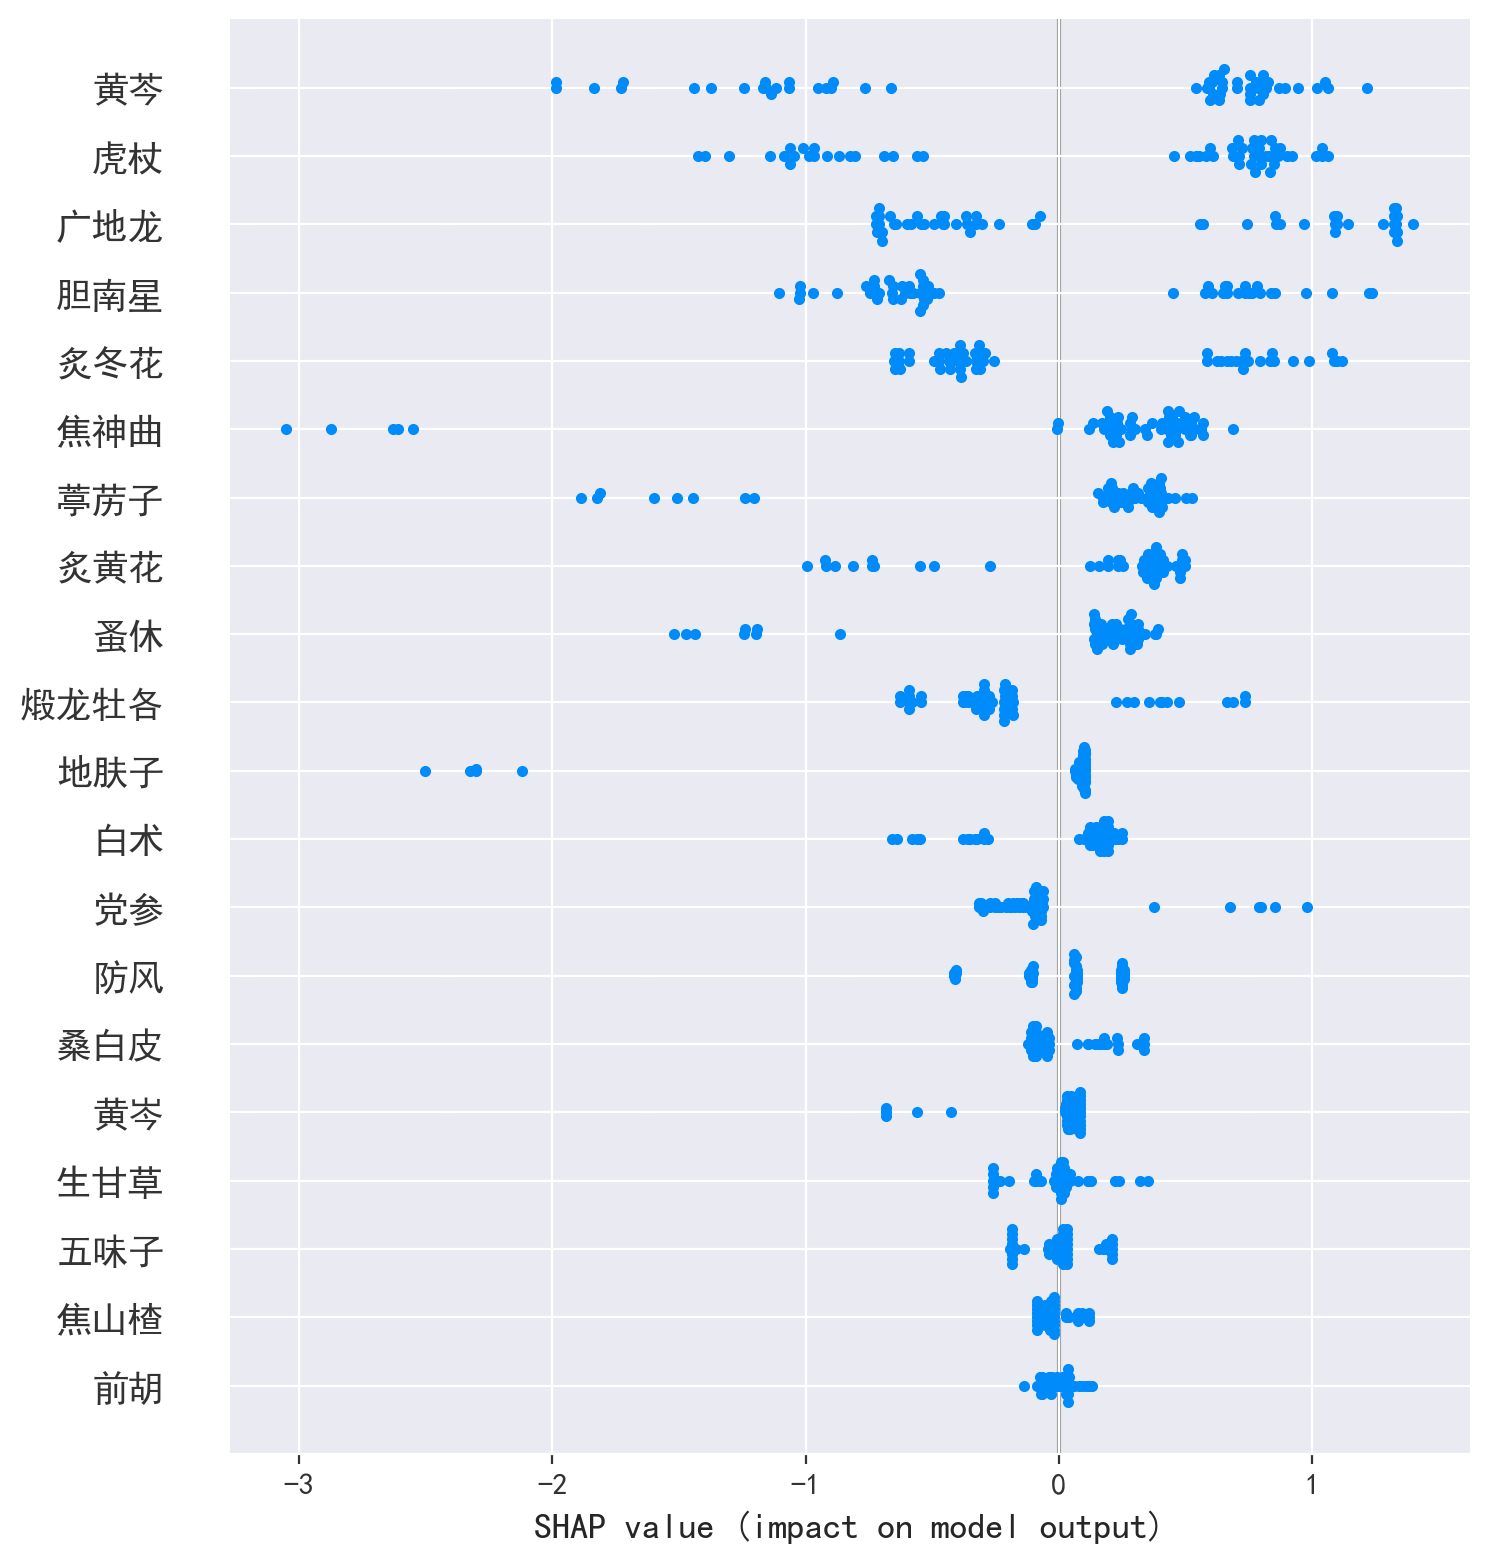

In [44]:
_,ax= plt.subplots(figsize=(6,6),dpi=200)
ax = shap.summary_plot(shap_values_XGBoost_train,cols,plot_type="dot")

In [45]:
# xgb.to_graphviz(xgbc_3)

Text(0.5, 0, 'Permutation Importance')

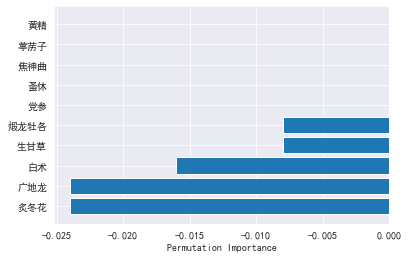

In [46]:
from sklearn.inspection import permutation_importance
xgb_permutation_importance = permutation_importance(xgbc_3,X_test,y_test,random_state=77)
sorted_idx = xgb_permutation_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx][:10],xgb_permutation_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")

## null importance

In [47]:
df = pd.read_excel('./input/xiaoerxiaochuan/data.xlsx')
df = df.dropna(axis=0,subset=['咳嗽分型']).reset_index()
df.drop(index=[11,82],inplace=True)
medicines = []
for i in df.columns:
    if re.match('药\d$',i):
        medicines += df[i].tolist()
medicines = list(set(medicines))
for item in ['？', np.nan, '1.桑白皮', '（1）炙黄芪', '（1）桑叶', '葶苈子（包）', '地肤子（包）', '黛蛤散','葶苈子（包)','葶苈','白']:
    if item in medicines:
        medicines.remove(item)
X = pd.DataFrame()
for i,row in df.iterrows():
    for j in row:
        if j in medicines:
            X.loc[i,j] = row[str(row[row==j].index.tolist()[0])+'剂量(g)']
X.replace(np.nan,0,inplace=True)
X['桑叶/桑白皮'].replace('各\d',4,regex=True,inplace=True)
X['煅龙牡'].replace('各\d',4,regex=True,inplace=True)
y = df['咳嗽分型']
# y.iplot(kind='hist', title= '咳嗽分型')
X = pd.concat([X,y],axis=1)
X = X.drop(X[(X['咳嗽分型']!='热性哮喘') & (X['咳嗽分型'] != '寒性哮喘')].index)
# X['咳嗽分型'].iplot(kind='hist', title= '咳嗽分型')
accuracy= []
recall =[]
roc_auc= []
precision = []
le = LabelEncoder()
y = X['咳嗽分型']
y = le.fit_transform(y)
X.drop(columns='咳嗽分型',inplace=True)
cols = X.columns
X[:] = StandardScaler().fit_transform(X.values)
print(datetime.datetime.now(),'\n数据预处理完成!')

2022-06-04 20:23:01.364317 
数据预处理完成!


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgbc_3 = xgb.XGBClassifier(random_state=0,scale_pos_weight=3,booster='gbtree',eval_metric='error')

xgbc_3.fit(X_train, y_train)
y_pred = xgbc_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

print(f"accuracy:{sum(accuracy)/5:.3f}\n",f"recall:{sum(recall)/5:.3f}\n",f"roc_auc:{sum(roc_auc)/5:.3f}\n",f"precision{sum(precision)/5:.3f}\n")
# result_df6 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=['XGBoost_adjusted_weight_3'])
# result_df6

accuracy:0.144
 recall:0.179
 roc_auc:0.106
 precision0.155



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

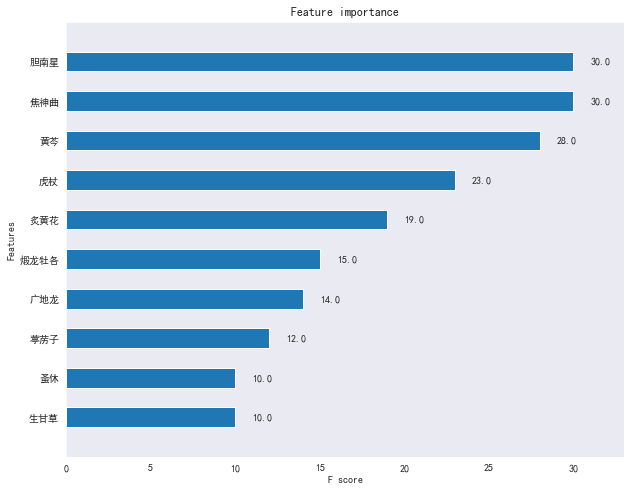

In [49]:
# 权重weight:在子树模型分裂时，用到的特征次数
from xgboost import plot_importance

_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='weight',grid=False,height=0.5,ax=ax,max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

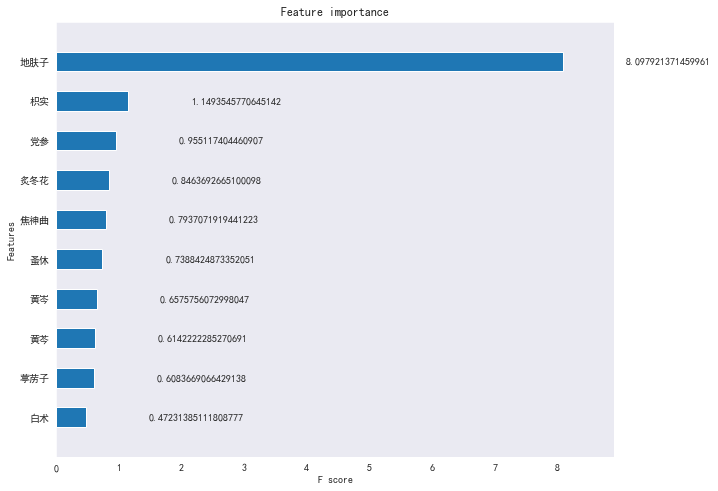

In [50]:
_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='gain',grid=False,height=0.5,ax=ax,max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

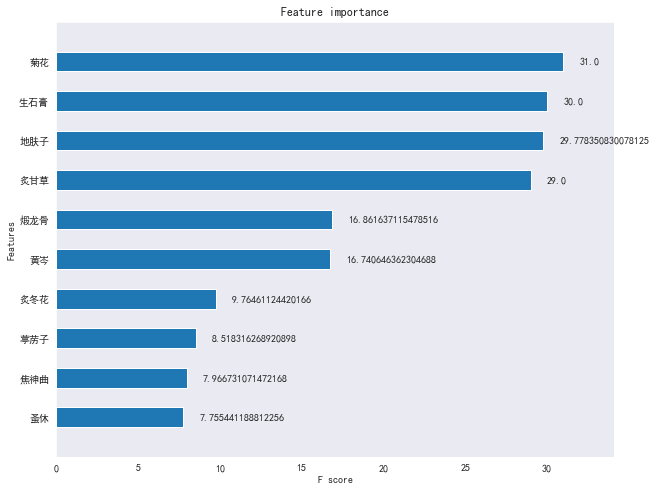

In [51]:
_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='cover',grid=False,height=0.5,ax=ax,max_num_features=10)

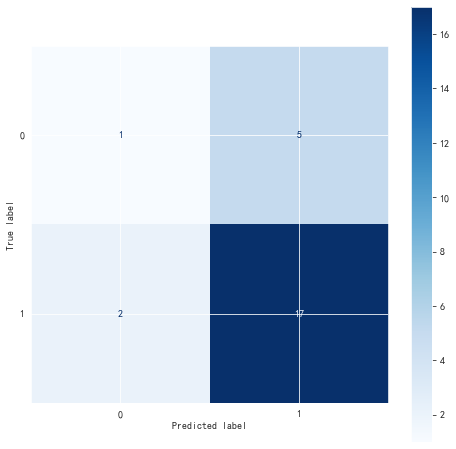

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_3, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

## SHAP Feature Importance


In [53]:
explainerxgbc = shap.TreeExplainer(xgbc_3)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)
print(datetime.datetime.now(),"\nXGBoost SHAP value训练完成!")

2022-06-04 20:23:01.970265 
XGBoost SHAP value训练完成!


In [54]:
shap_values_XGBoost_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.04648061,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05739193,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05739193,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.05642096,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0481404 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0428399 ,
        0.        ]], dtype=float32)

In [55]:
SHAP_XGBoost=pd.DataFrame(data=shap_values_XGBoost_train,columns=X_train.columns).mean(axis=0).sort_values(ascending=False)
SHAP_XGBoost.drop(index=SHAP_XGBoost[SHAP_XGBoost==0].index,inplace=True)
SHAP_XGBoost.round(3).to_csv(output_path+'XGBoost_SHAP.csv')
print(datetime.datetime.now())

2022-06-04 20:23:02.008262


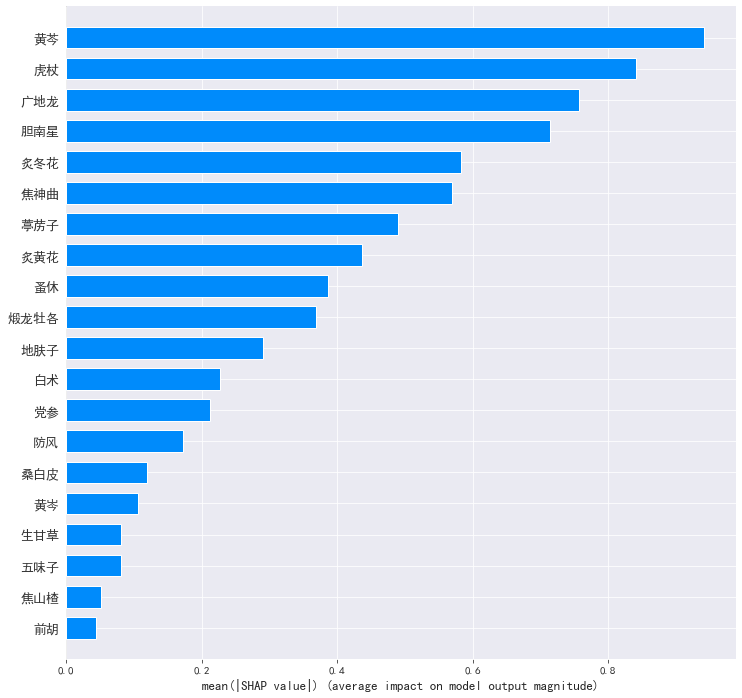

In [56]:
shap.summary_plot(shap_values_XGBoost_train, cols,plot_type="bar",plot_size=(12,12))

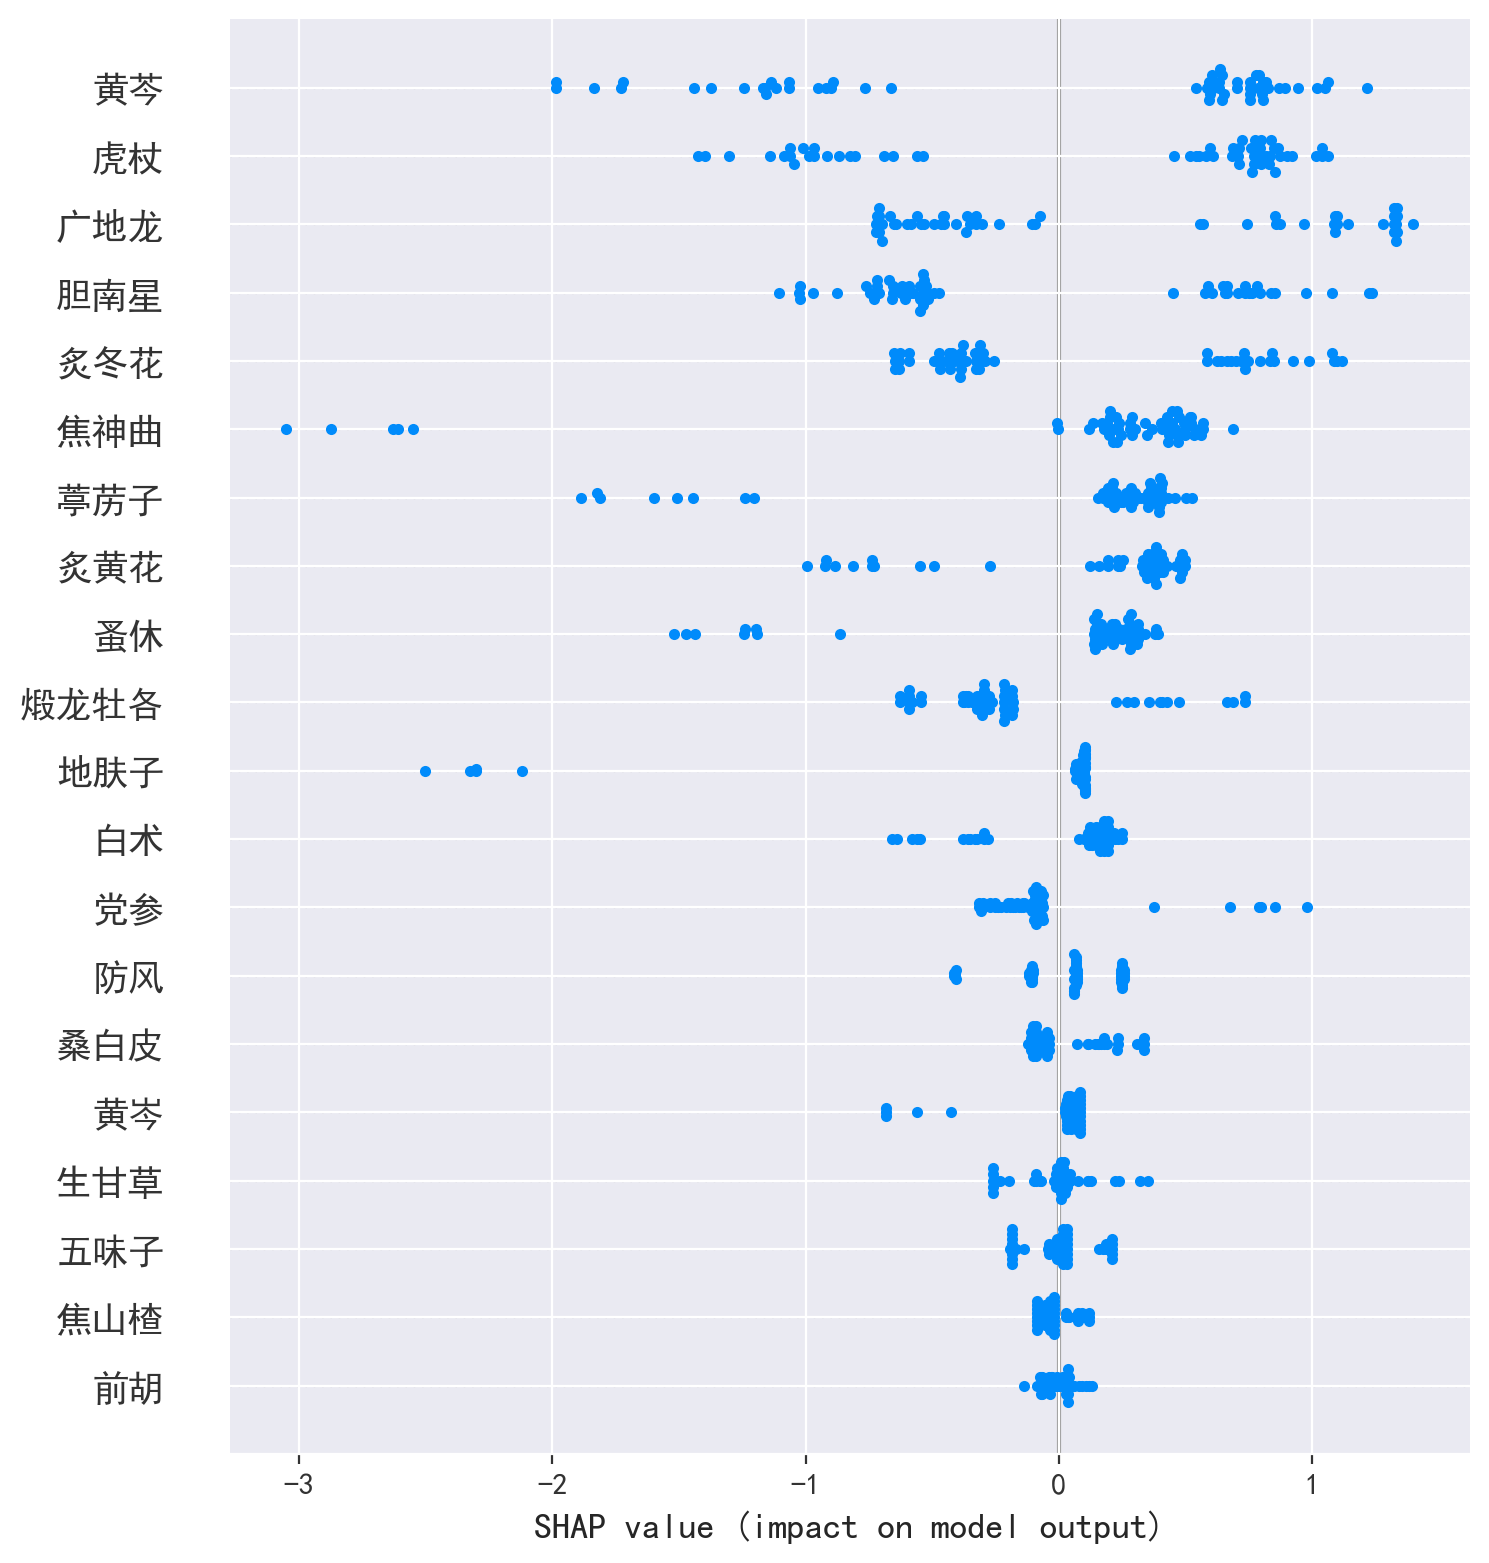

In [57]:
_,ax= plt.subplots(figsize=(6,6),dpi=200)
ax = shap.summary_plot(shap_values_XGBoost_train,cols,plot_type="dot")

In [58]:
# xgb.to_graphviz(xgbc_3)

Text(0.5, 0, 'Permutation Importance')

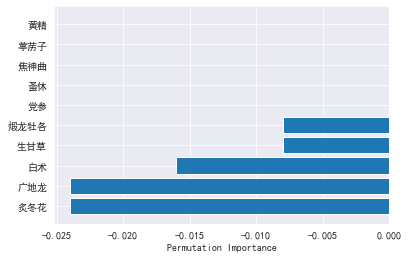

In [59]:
from sklearn.inspection import permutation_importance
xgb_permutation_importance = permutation_importance(xgbc_3,X_test,y_test,random_state=77)
sorted_idx = xgb_permutation_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx][:10],xgb_permutation_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")

## 中药药性

In [60]:
total = pd.DataFrame(columns=['药名','四气','五味','升降浮沉','归经'])
with pd.ExcelWriter('./input/xiaoerxiaochuan/total-中药学教材.xlsx') as writer:
    for i in pd.ExcelFile('./input/xiaoerxiaochuan/中药药性-中药学教材.xlsx').sheet_names:
        data = pd.read_excel('./input/xiaoerxiaochuan/中药药性-中药学教材.xlsx',sheet_name=i)
        data.to_excel(writer,sheet_name=i,index=False,header=True)
        total = pd.concat([total,data],axis=0)
        print(i,total.columns,data.columns)
    total.to_excel(writer,sheet_name='汇总',index=False,header=True)

解表药-发散风寒药 Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object') Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object')
解表药-发散风热药 Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object') Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object')
清热药-清热泻火药 Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object') Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object')
清热药-清热燥湿药 Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object') Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object')
清热药-清热解毒药 Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object') Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object')
清热药-清热凉血药 Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object') Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object')
清热药-清虚热药 Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object') Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object')
泻下药-攻下药 Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object') Index(['药名', '四气', '五味', '升降浮沉', '归经'], dtype='object')
泻下药-润下药 Index(['药名', '四气', 

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgbc_3 = xgb.XGBClassifier(random_state=0,scale_pos_weight=3,booster='gbtree',eval_metric='error')

xgbc_3.fit(X_train, y_train)
y_pred = xgbc_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

print(f"accuracy:{sum(accuracy)/5:.3f}\n",f"recall:{sum(recall)/5:.3f}\n",f"roc_auc:{sum(roc_auc)/5:.3f}\n",f"precision{sum(precision)/5:.3f}\n")
# result_df6 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=['XGBoost_adjusted_weight_3'])
# result_df6

accuracy:0.288
 recall:0.358
 roc_auc:0.212
 precision0.309



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

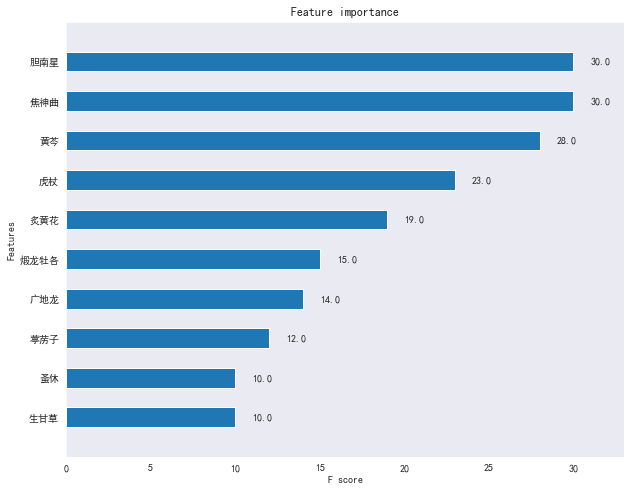

In [62]:
# 权重weight:在子树模型分裂时，用到的特征次数
from xgboost import plot_importance

_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='weight',grid=False,height=0.5,ax=ax,max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

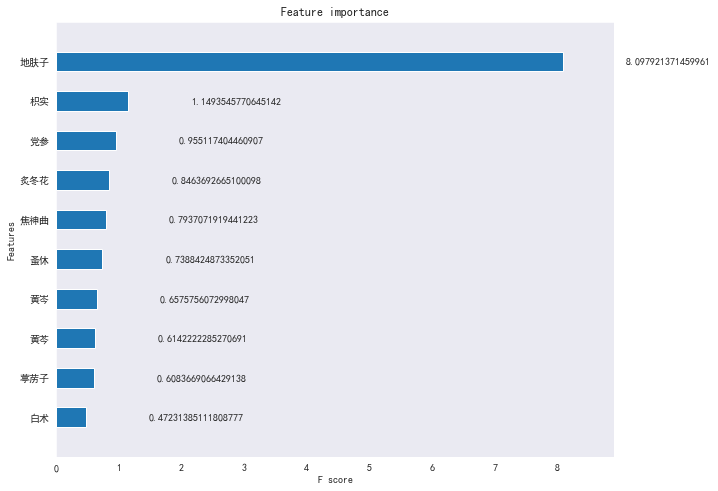

In [63]:
_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='gain',grid=False,height=0.5,ax=ax,max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

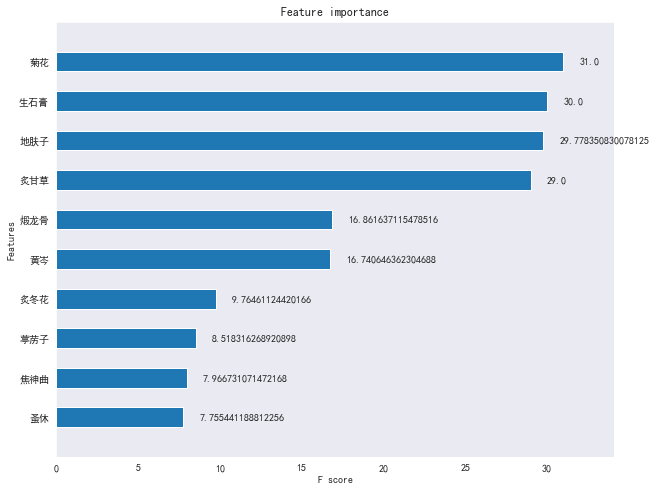

In [64]:
_,ax = plt.subplots(figsize=(10,8))
plot_importance(xgbc_3,importance_type='cover',grid=False,height=0.5,ax=ax,max_num_features=10)

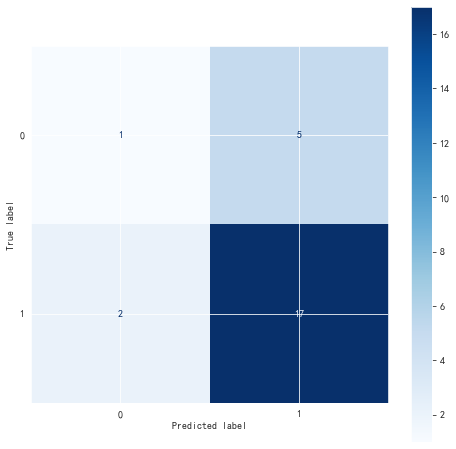

In [65]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_3, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

## SHAP Feature Importance


In [66]:
explainerxgbc = shap.TreeExplainer(xgbc_3)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)
print(datetime.datetime.now(),"\nXGBoost SHAP value训练完成!")

2022-06-04 20:23:06.586264 
XGBoost SHAP value训练完成!


In [67]:
shap_values_XGBoost_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.04648061,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05739193,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05739193,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.05642096,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0481404 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0428399 ,
        0.        ]], dtype=float32)

In [68]:
SHAP_XGBoost=pd.DataFrame(data=shap_values_XGBoost_train,columns=X_train.columns).mean(axis=0).sort_values(ascending=False)
SHAP_XGBoost.drop(index=SHAP_XGBoost[SHAP_XGBoost==0].index,inplace=True)
SHAP_XGBoost.round(3).to_csv(output_path+'XGBoost_SHAP.csv')
print(datetime.datetime.now())

2022-06-04 20:23:06.625265


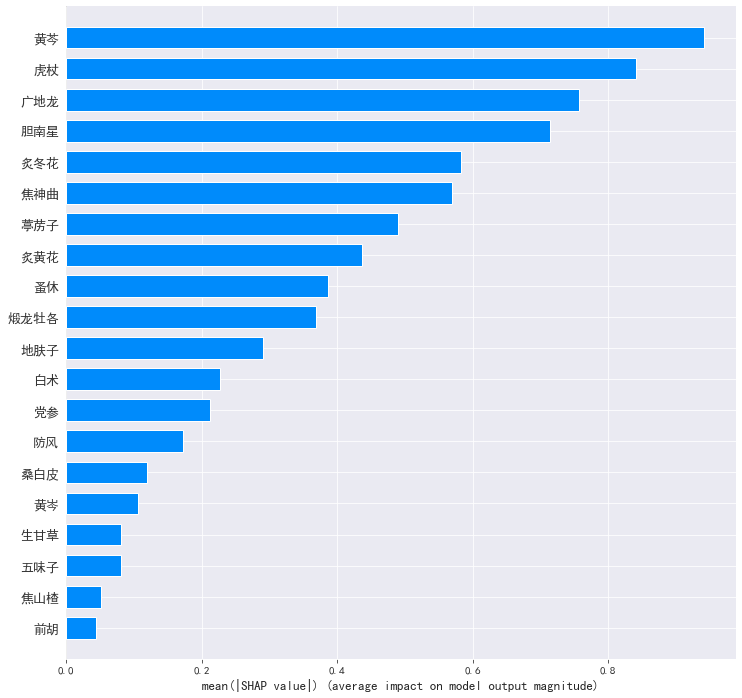

In [69]:
shap.summary_plot(shap_values_XGBoost_train, cols,plot_type="bar",plot_size=(12,12))

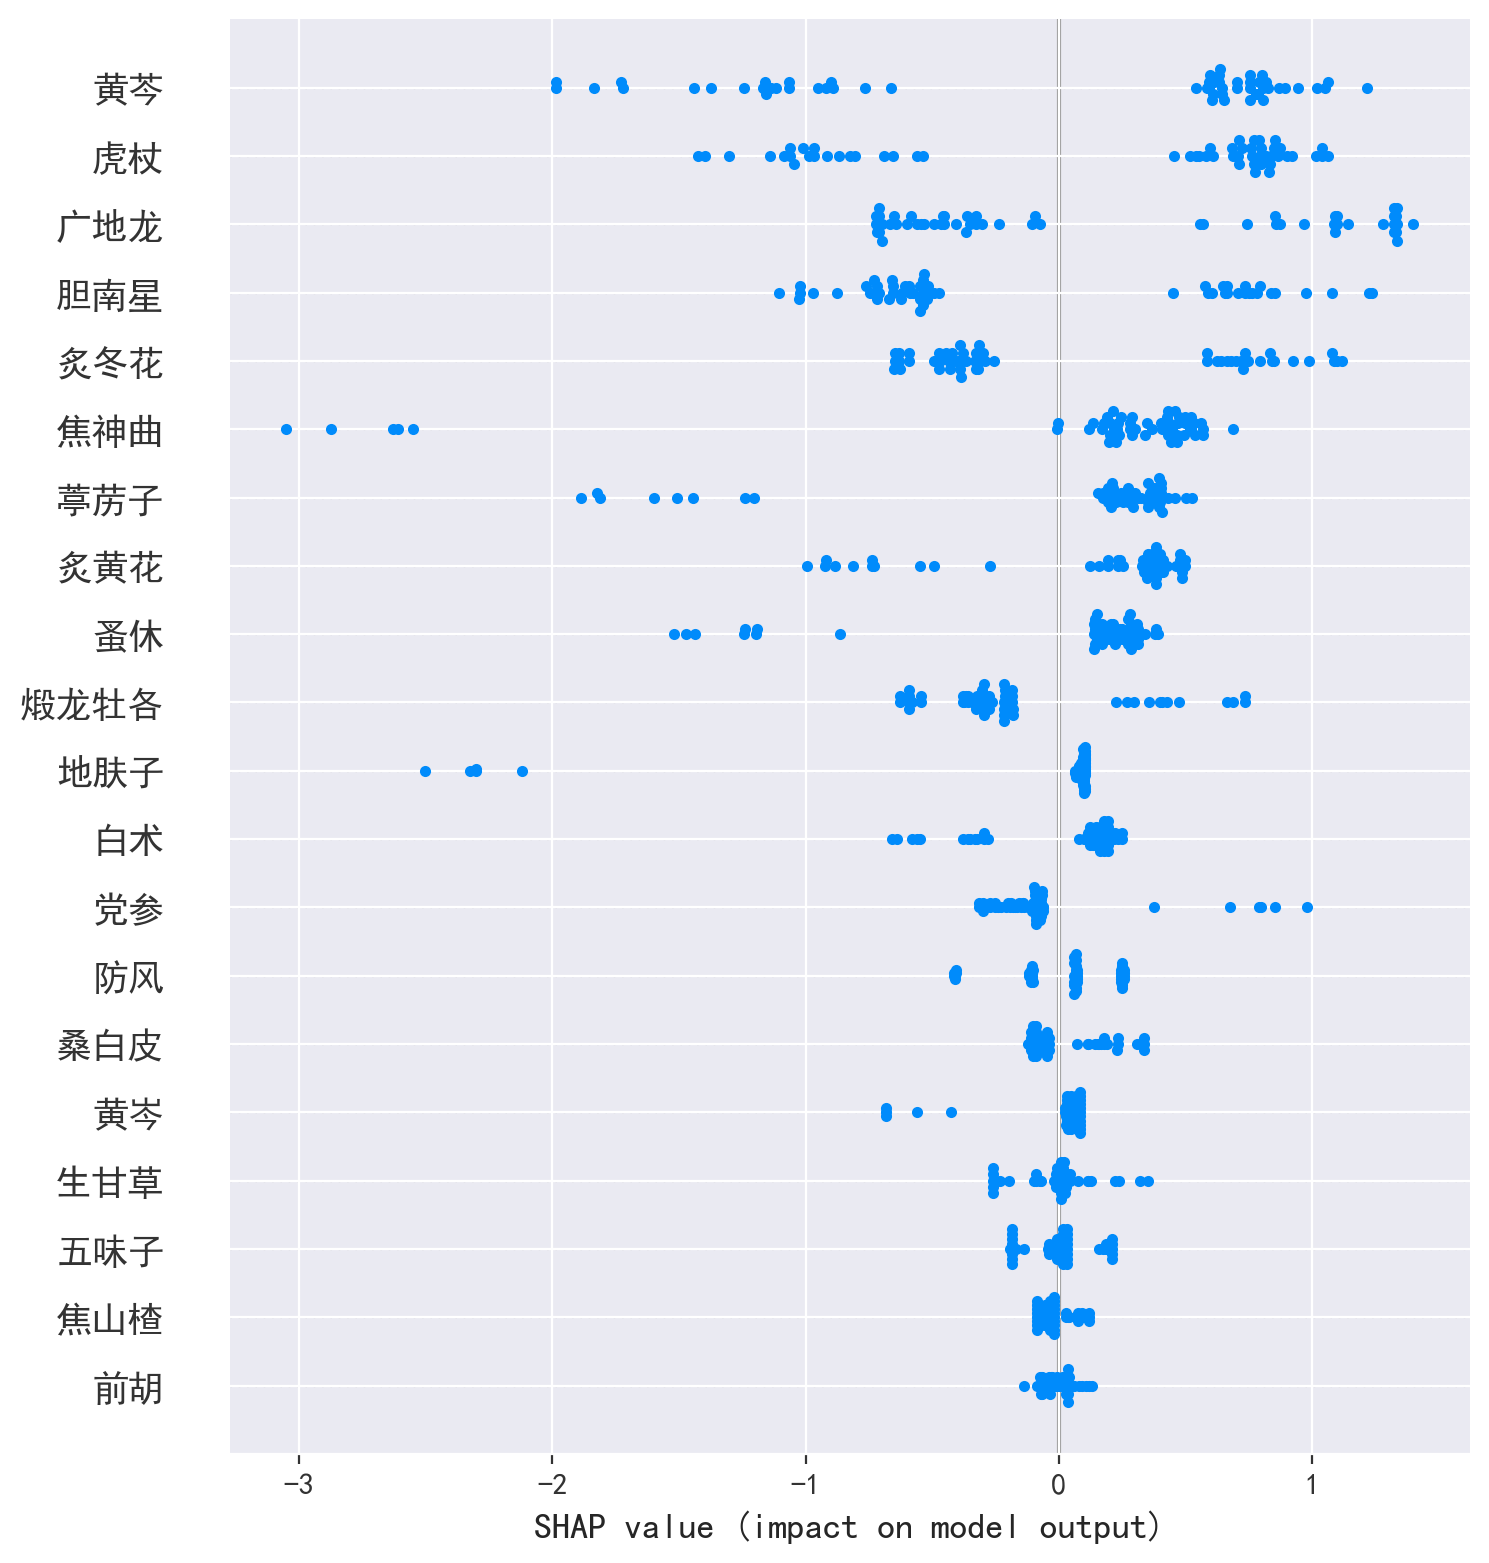

In [70]:
_,ax= plt.subplots(figsize=(6,6),dpi=200)
ax = shap.summary_plot(shap_values_XGBoost_train,cols,plot_type="dot")

In [71]:
# xgb.to_graphviz(xgbc_3)

Text(0.5, 0, 'Permutation Importance')

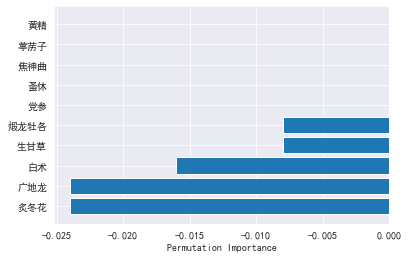

In [72]:
from sklearn.inspection import permutation_importance
xgb_permutation_importance = permutation_importance(xgbc_3,X_test,y_test,random_state=77)
sorted_idx = xgb_permutation_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx][:10],xgb_permutation_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")

## 中药

In [74]:
total = pd.DataFrame()
with pd.ExcelWriter('./input/xiaoerxiaochuan/中药药性-中药学教材.xlsx') as writer:
    for i in pd.ExcelFile('./input/xiaoerxiaochuan/中药药性-中药学教材.xlsx'):
        data = pd.read_excel('',sheet_name=i)
        total = pd.concat([total,data],axis=0)
        data.to_excel(writer,header=True,sheet_name=i)
    total.to_excel(writer,header=True,sheet_name='汇总')
total

IndexError: At least one sheet must be visible